In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold

import os
from glob import glob

from utils.config import save_dict_as_yaml, create_dir_suffix
from utils.preprocessing.numpy import get_idxs_of_annotated_slices
from utils.datasets.foscal.create_dataset import get_foscal_train_val_test_patients, create_foscal_dataset

# Helpers

In [2]:
data_dir = "data/"

def foscal_train_val_test(
    source_dset_dir,
    volumes,
    slices,
    patches,
    z_norm,
    min_max_norm,
):

    check_norm_flags(z_norm, min_max_norm)
    check_spatial_flags(volumes, slices, patches)
    modalities = ["ADC"]

    # Get the patients for each split.
    (
        train_patients_orig,
        train_patients,
        valid_patients,
        test_patients,
    ) = get_foscal_train_val_test_patients(source_dset_dir)

    # Create the directory to store all the data.
    dir_suffix = create_dir_suffix(
        volumes=volumes,
        slices=slices,
        patches=patches,
        z_norm=z_norm,
        min_max_norm=min_max_norm,
    )
    target_dset_dir = os.path.join(data_dir, f"FOSCAL_{dir_suffix}")
    print(f"Created directory for the dataset at: {target_dset_dir}\n")
    os.makedirs(target_dset_dir, exist_ok=True)

    # Create training and validation sets.
    if z_norm:
        normalization = "z"
    elif min_max_norm:
        normalization = "min_max"

    # Create the TFRecords for full_training, training, valid and test.
    tfrecords_dir = os.path.join(target_dset_dir, "tfrecords")
    os.makedirs(tfrecords_dir, exist_ok=True)
    full_train_tfrecord_path, num_full_train_samples = create_foscal_dataset(
        tfrecords_dir,
        train_patients_orig,
        volumes=volumes,
        slices=slices,
        patches=patches,
        normalization=normalization,
        modalities=modalities,
        dset_split="full_train",
    )
    train_tfrecord_path, num_train_samples = create_foscal_dataset(
        tfrecords_dir,
        train_patients,
        volumes=volumes,
        slices=slices,
        patches=patches,
        normalization=normalization,
        modalities=modalities,
        dset_split="train",
    )

    # Validation and test metrics are always calculated at volume-level.
    # Hence, serialize volumes to the TFRecords. Test TFRecord is not created
    # because it patients do not have masks. Other script will be used.
    valid_tfrecord_path, num_valid_samples = create_foscal_dataset(
        tfrecords_dir,
        valid_patients,
        volumes=True,
        slices=False,
        patches=False,
        normalization=normalization,
        modalities=modalities,
        dset_split="valid",
    )

    # Save the patient paths to the dataset dir.
    patients_dir = os.path.join(target_dset_dir, "patients")
    os.makedirs(patients_dir, exist_ok=True)
    full_train_patients_path = os.path.join(patients_dir, "full_train_patients.txt")
    train_patients_path = os.path.join(patients_dir, "train_patients.txt")
    valid_patients_path = os.path.join(patients_dir, "valid_patients.txt")
    test_patients_path = os.path.join(patients_dir, "test_patients.txt")
    np.savetxt(full_train_patients_path, train_patients_orig, fmt="%s")
    np.savetxt(train_patients_path, train_patients, fmt="%s")
    np.savetxt(valid_patients_path, valid_patients, fmt="%s")
    np.savetxt(test_patients_path, test_patients, fmt="%s")

    # Save dataset configuration as YAML file.
    dset_config = {
        "dset_name": "FOSCAL",
        "normalization": normalization,
        "full_train_tfrecord": get_path_and_parent_dir(full_train_tfrecord_path),
        "train_tfrecord": get_path_and_parent_dir(train_tfrecord_path),
        "valid_tfrecord": get_path_and_parent_dir(valid_tfrecord_path),
        "full_train_patients_path": get_path_and_parent_dir(full_train_patients_path),
        "train_patients_path": get_path_and_parent_dir(train_patients_path),
        "valid_patients_path": get_path_and_parent_dir(valid_patients_path),
        "test_patients_path": get_path_and_parent_dir(test_patients_path),
        "num_full_train_samples": num_full_train_samples,
        "num_train_samples": num_train_samples,
        "num_valid_samples": num_valid_samples,
        "modalities": modalities,
    }
    dset_config_path = os.path.join(target_dset_dir, "dset_config.yml")
    save_dict_as_yaml(dset_config_path, dset_config)


def check_norm_flags(z_norm: bool, min_max_norm: bool):
    """Normalization argument testing: Check if only one argument
    was marked"""
    if z_norm and min_max_norm:
        raise ValueError(
            "Both z_norm and min_max_norm are True. Only one could "
            "be True per execution."
        )
    elif (not z_norm) and (not min_max_norm):
        raise ValueError(
            "Both z_norm and min_max_norm are False. One of them should True."
        )


def check_spatial_flags(volumes: bool, slices: bool, patches: bool):
    """Dataset type argument testing: Raise an exception if
    the user marked two or more modes."""
    if volumes and slices and patches:
        raise ValueError(
            "All the arguments were set to True. Only one of volumes"
            " slices and patches should be True per execution"
        )
    elif not (volumes ^ slices ^ patches):
        raise ValueError(
            "Set one, and only one, argument of volumes, slices and " "patches to True."
        )


def get_path_and_parent_dir(path: str) -> str:
    """Return only the parent dir and filename of a path

    e.g. 'dir/dir2/dir3/filename.txt' -> 'dir3/filename.txt'
    """
    return "/".join(path.split("/")[-2:])

# Hyperparameters

In [3]:
volumes = False
slices = True
patches = False
z_norm = False
min_max_norm = True
modalities = ["ADC", "DWI"]

# Create the folds for the experiments

Create the 5-fold dataset

In [4]:
os.makedirs("folds", exist_ok=True)
dset_dir = "/data/Datasets/stroke/ISBI_FOSCAL/"
patient_dirs = glob(os.path.join(dset_dir, "*"))
patient_dirs = np.array(patient_dirs)

kf = KFold(shuffle=True, random_state=3)
for i, (train_index, test_index) in enumerate(kf.split(patient_dirs)):
    
    train_patients = patient_dirs[train_index]
    test_patients = patient_dirs[test_index]

    save_dict_as_yaml(
        f"folds/fold_{i}_patients.yml", 
        {
            "train": train_patients.tolist(), 
            "test": test_patients.tolist()
        }
    )

    # Create the directory to store all the data.
    dir_suffix = create_dir_suffix(
        volumes=volumes,
        slices=slices,
        patches=patches,
        z_norm=z_norm,
        min_max_norm=min_max_norm,
    )

    # Create the directory for each fold.
    target_dset_dir = os.path.join(data_dir, f"FOSCAL_{dir_suffix}", f"fold_{i}")
    print(f"Created directory for the dataset at: {target_dset_dir}\n")
    os.makedirs(target_dset_dir, exist_ok=True)

    # Create training and validation sets.
    if z_norm:
        normalization = "z"
    elif min_max_norm:
        normalization = "min_max"

    # Create the TFRecords for full_training, training, valid and test.
    tfrecords_dir = os.path.join(target_dset_dir, "tfrecords")
    os.makedirs(tfrecords_dir, exist_ok=True)

    train_tfrecord_path, num_train_samples = create_foscal_dataset(
        tfrecords_dir,
        train_patients,
        volumes=volumes,
        slices=slices,
        patches=patches,
        normalization=normalization,
        modalities=modalities,
        dset_split="train",
    )

    # Validation and test metrics are always calculated at volume-level.
    # Hence, serialize volumes to the TFRecords. Test TFRecord is not created
    # because it patients do not have masks. Other script will be used.
    test_tfrecord_path, num_test_samples = create_foscal_dataset(
        tfrecords_dir,
        test_patients,
        volumes=True,
        slices=False,
        patches=False,
        normalization=normalization,
        modalities=modalities,
        dset_split="test",
    )

    # Save the patient paths to the dataset dir.
    patients_dir = os.path.join(target_dset_dir, "patients")
    os.makedirs(patients_dir, exist_ok=True)
    full_train_patients_path = os.path.join(patients_dir, "full_train_patients.txt")
    train_patients_path = os.path.join(patients_dir, "train_patients.txt")
    test_patients_path = os.path.join(patients_dir, "test_patients.txt")
    np.savetxt(train_patients_path, train_patients, fmt="%s")
    np.savetxt(test_patients_path, test_patients, fmt="%s")

    # Save dataset configuration as YAML file.
    dset_config = {
        "dset_name": "FOSCAL",
        "normalization": normalization,
        "train_tfrecord": get_path_and_parent_dir(train_tfrecord_path),
        "full_train_patients_path": get_path_and_parent_dir(full_train_patients_path),
        "train_patients_path": get_path_and_parent_dir(train_patients_path),
        "test_patients_path": get_path_and_parent_dir(test_patients_path),
        "num_train_samples": num_train_samples,
        "modalities": modalities,
    }
    dset_config_path = os.path.join(target_dset_dir, "dset_config.yml")
    save_dict_as_yaml(dset_config_path, dset_config)


Created directory for the dataset at: data/FOSCAL_slices_min_max_norm/fold_0



Creating test dataset: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Created directory for the dataset at: data/FOSCAL_slices_min_max_norm/fold_1



Creating test dataset: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Created directory for the dataset at: data/FOSCAL_slices_min_max_norm/fold_2



Creating test dataset: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Created directory for the dataset at: data/FOSCAL_slices_min_max_norm/fold_3



Creating test dataset: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Created directory for the dataset at: data/FOSCAL_slices_min_max_norm/fold_4



Creating test dataset: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


# Test you're able to load the created datasets

In [5]:
from dataloader import TFSlicesDataloader, TFSlicesValidationDataloader
train_dataloader = TFSlicesDataloader(
    "/home/sangohe/projects/isbi2023-foscal/data/FOSCAL_slices_min_max_norm/fold_0/tfrecords/train.tfrecord",
    modalities=modalities,
    slice_size=224,
    batch_size=32,
    deep_supervision=False,
    num_lods=4,
    augmentations=True,
    sample_weights=True,
    class_weights=[1.0, 3.0],
    cache=False,
    prefetch=False,
    shuffle_buffer=0
)

test_dataloader = TFSlicesValidationDataloader(
    "/home/sangohe/projects/isbi2023-foscal/data/FOSCAL_slices_min_max_norm/fold_0/tfrecords/test.tfrecord",
    modalities=modalities,
    slice_size=224,
    deep_supervision=False,
    num_lods=4,
    cache=False,
    prefetch=False
)

# Plot some samples to validate the data pipeline

## Train dataset

In [6]:
train_dset = train_dataloader.get_dataset()
for x_train, y_train, z_train in train_dset.take(1):
    if isinstance(x_train, tuple):
        for i in range(len(x_train)):
            print(f"{modalities[i]} shape: {x_train[i].shape}")
    if isinstance(y_train, tuple):
        for i in range(len(y_train)):
            print(f"{modalities[i]} mask shape: {y_train[i].shape}")
    if isinstance(z_train, tuple):
        for i in range(len(z_train)):
            print(f"{modalities[i]} mask weights shape: {z_train[i].shape}")

ADC shape: (32, 224, 224, 1)
DWI shape: (32, 224, 224, 1)
ADC mask shape: (32, 224, 224, 1)
DWI mask shape: (32, 224, 224, 1)
ADC mask weights shape: (32, 224, 224, 1)
DWI mask weights shape: (32, 224, 224, 1)


### ADC

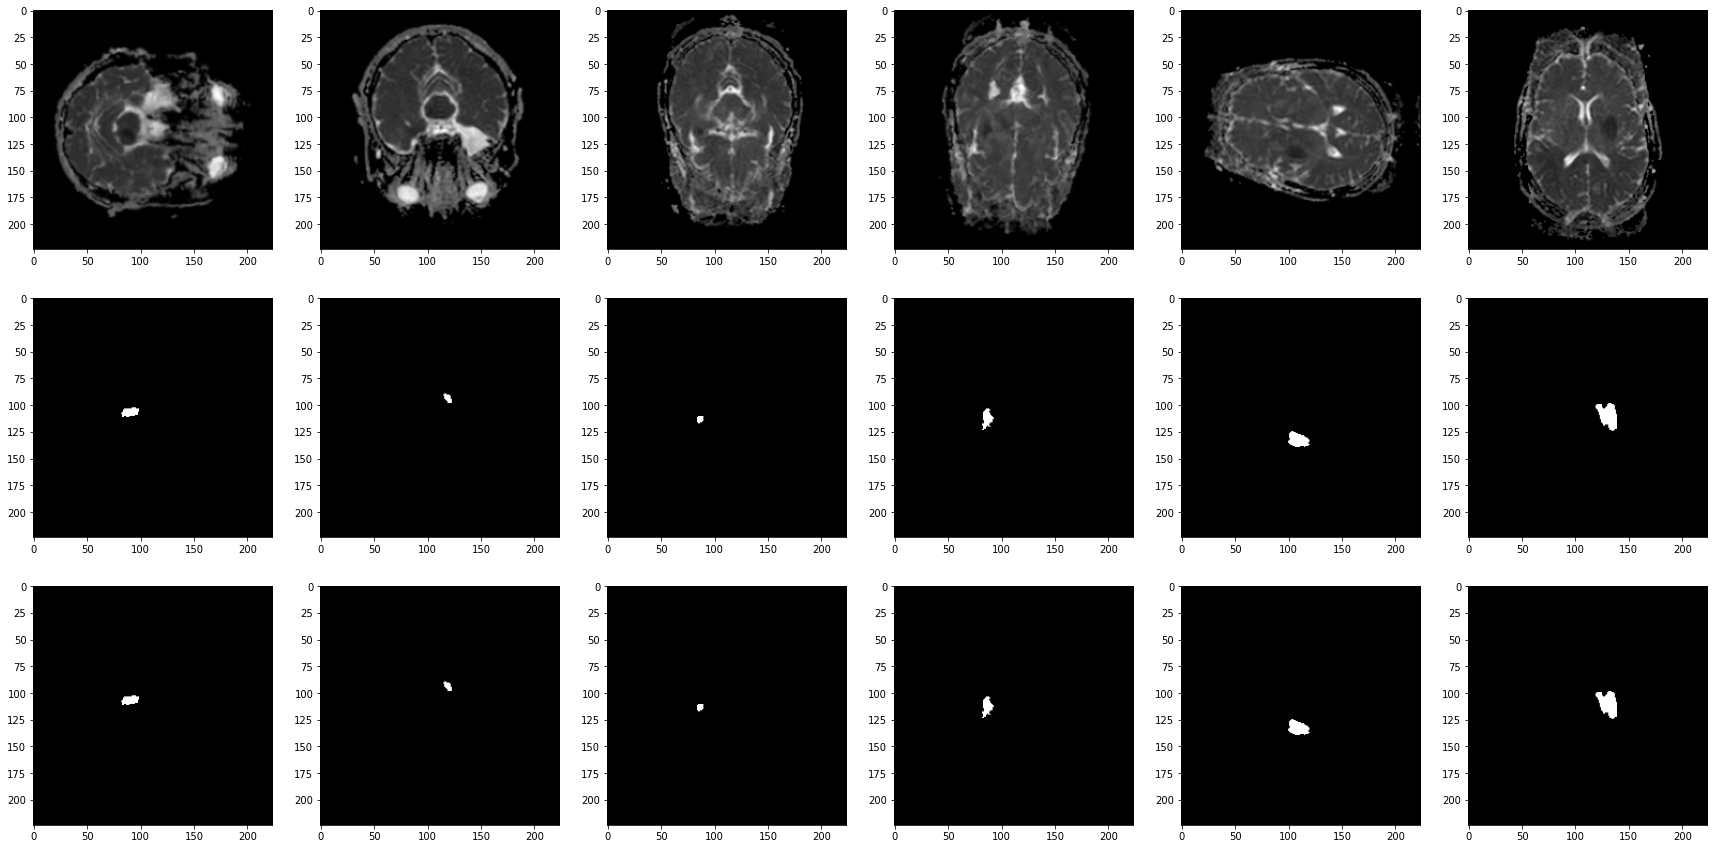

In [7]:
sample_mask = y_train[0].numpy()[..., 0]
sample_adc = x_train[0].numpy()[..., 0]
sample_mask_weights = z_train[0].numpy()[..., 0]

annotated_idxs = get_idxs_of_annotated_slices(sample_mask)
annotated_sample_adc = sample_adc[annotated_idxs]
annotated_sample_mask = sample_mask[annotated_idxs]
annotated_sample_mask_weights = sample_mask_weights[annotated_idxs]

num_slices = annotated_sample_mask.shape[0]
fig, axs = plt.subplots(3, num_slices, figsize=(5 * num_slices, 15))
for i in range(num_slices):
    axs[0, i].imshow(annotated_sample_adc[i], cmap="gray")
    axs[1, i].imshow(annotated_sample_mask[i], cmap="gray")
    axs[2, i].imshow(annotated_sample_mask_weights[i], cmap="gray")


### DWI

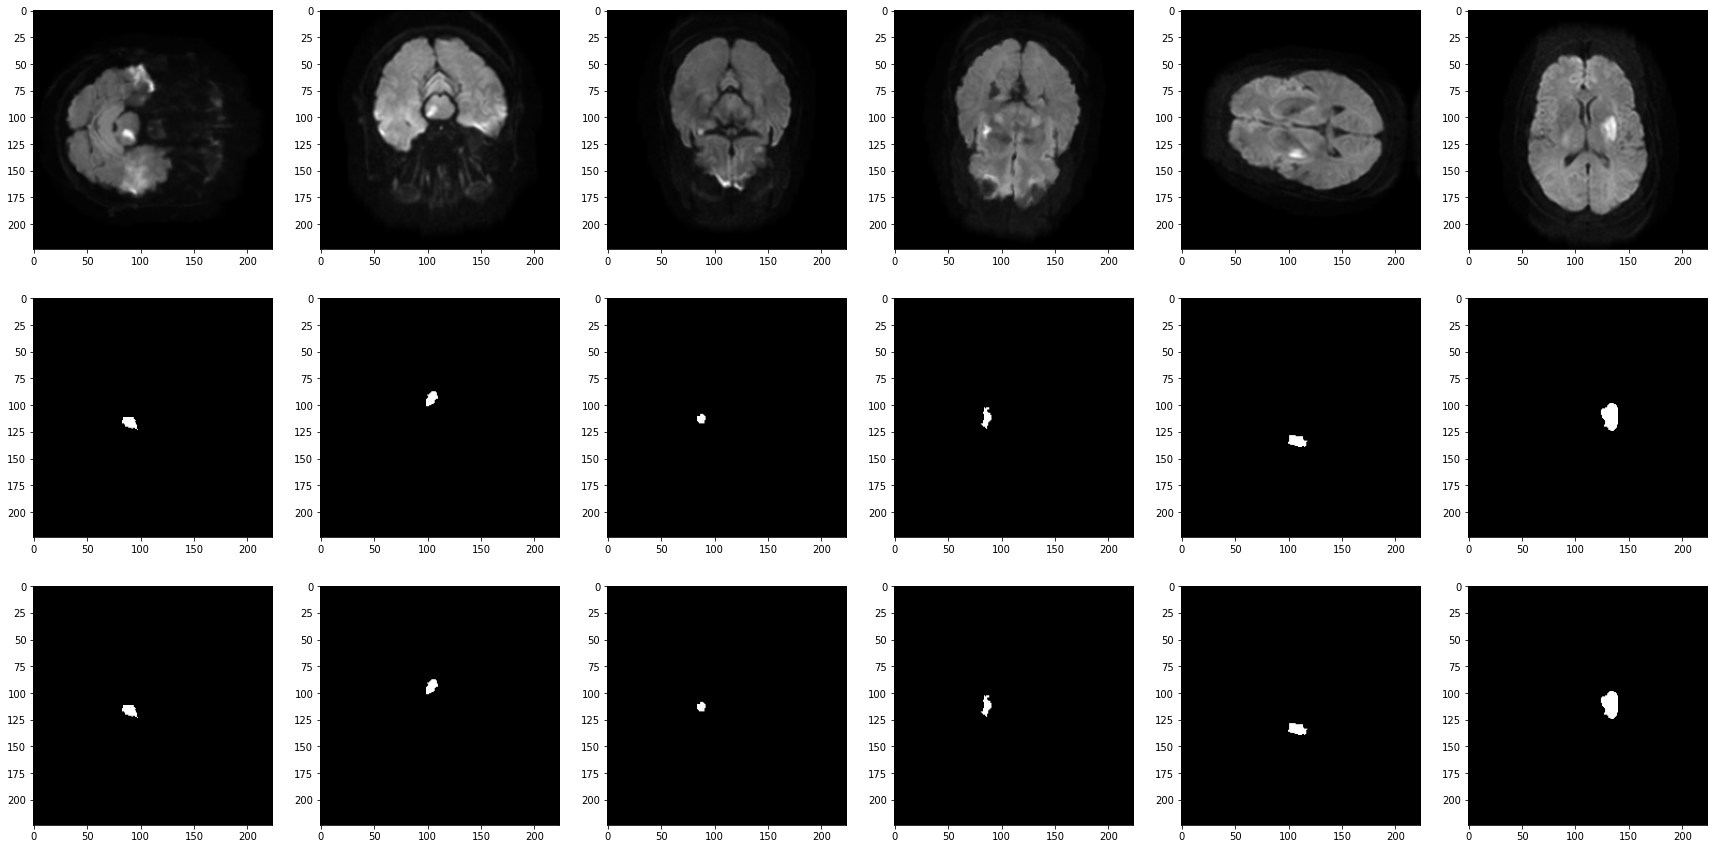

In [8]:
sample_dwi = x_train[1].numpy()[..., 0]
sample_mask = y_train[1].numpy()[..., 0]
sample_mask_weights = z_train[1].numpy()[..., 0]

annotated_idxs = get_idxs_of_annotated_slices(sample_mask)
annotated_sample_dwi = sample_dwi[annotated_idxs]
annotated_sample_mask = sample_mask[annotated_idxs]
annotated_sample_mask_weights = sample_mask_weights[annotated_idxs]

num_slices = annotated_sample_mask.shape[0]
fig, axs = plt.subplots(3, num_slices, figsize=(5 * num_slices, 15))
for i in range(num_slices):
    axs[0, i].imshow(annotated_sample_dwi[i], cmap="gray")
    axs[1, i].imshow(annotated_sample_mask[i], cmap="gray")
    axs[2, i].imshow(annotated_sample_mask_weights[i], cmap="gray")

## Test dataset

In [17]:
test_dset = test_dataloader.get_dataset()
for x_test, y_test in test_dset.take(2):
    if isinstance(x_test, tuple):
        for i in range(len(x_test)):
            print(f"{modalities[i]} shape: {x_test[i].shape}")
    if isinstance(y_test, tuple):
        for i in range(len(y_test)):
            print(f"{modalities[i]} mask shape: {y_test[i].shape}")

ADC shape: (25, 224, 224, 1)
DWI shape: (25, 224, 224, 1)
ADC mask shape: (25, 224, 224, 1)
DWI mask shape: (25, 224, 224, 1)
ADC shape: (26, 224, 224, 1)
DWI shape: (26, 224, 224, 1)
ADC mask shape: (26, 224, 224, 1)
DWI mask shape: (26, 224, 224, 1)


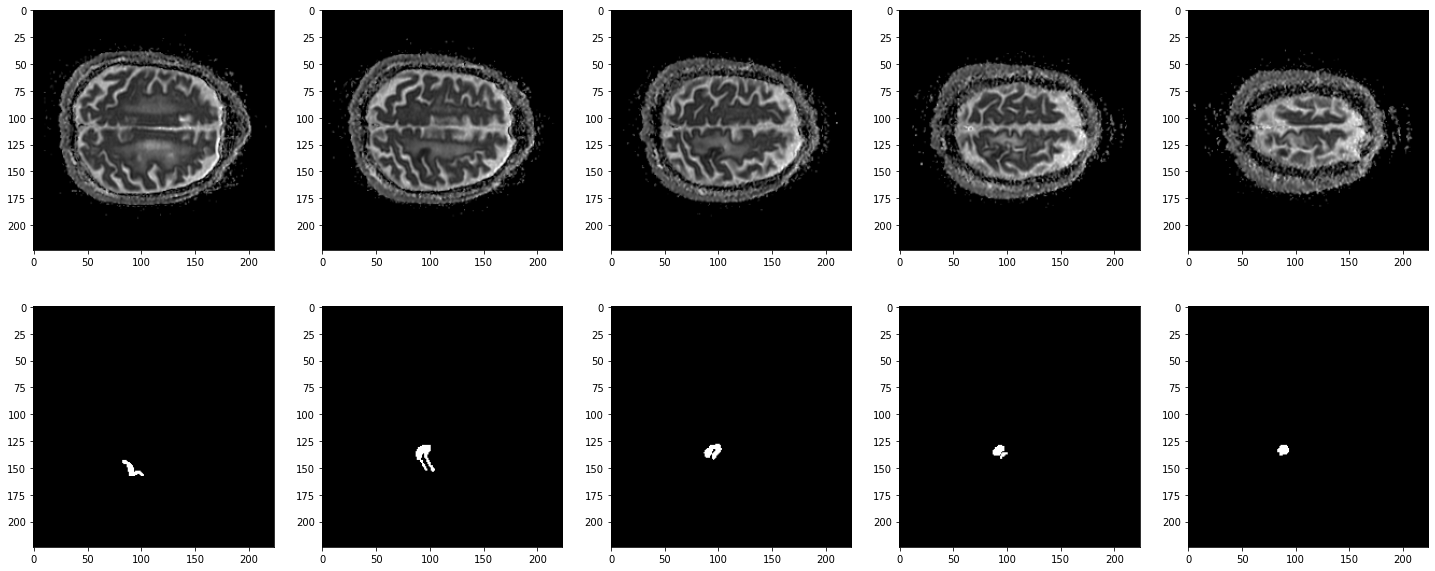

In [18]:
sample_adc = x_test[0].numpy()[..., 0]
sample_mask = y_test[0].numpy()[..., 0]

annotated_idxs = get_idxs_of_annotated_slices(sample_mask)
annotated_sample_adc = sample_adc[annotated_idxs]
annotated_sample_mask = sample_mask[annotated_idxs]

num_slices = annotated_sample_mask.shape[0]
fig, axs = plt.subplots(2, num_slices, figsize=(5 * num_slices, 10))
for i in range(num_slices):
    if num_slices > 1:
        axs[0, i].imshow(annotated_sample_adc[i], cmap="gray")
        axs[1, i].imshow(annotated_sample_mask[i], cmap="gray")
    else:
        axs[0].imshow(annotated_sample_adc[i], cmap="gray")
        axs[1].imshow(annotated_sample_mask[i], cmap="gray")
